In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import re
import plotly.graph_objects as go
from scipy.stats import ttest_ind
from sklearn.metrics import auc, roc_curve, classification_report

import warnings
warnings.filterwarnings('ignore')

### Import dataset

In [2]:
email = pd.read_csv("C:/Sophia/School!!!/2023 Spring 1/DS take home/7.email/email_table.csv")
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [3]:
email_opened = pd.read_csv("C:/Sophia/School!!!/2023 Spring 1/DS take home/7.email/email_opened_table.csv")
email_opened.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [4]:
link_clicked = pd.read_csv("C:/Sophia/School!!!/2023 Spring 1/DS take home/7.email/link_clicked_table.csv")
link_clicked.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [5]:
email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [6]:
email_opened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  10345 non-null  int64
dtypes: int64(1)
memory usage: 80.9 KB


In [7]:
link_clicked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  2119 non-null   int64
dtypes: int64(1)
memory usage: 16.7 KB


##### Make sure that all tables only have records of each customer once.

In [8]:
email['email_id'].nunique()

100000

In [9]:
len(email['email_id'])

100000

In [10]:
email_opened['email_id'].nunique()

10345

In [11]:
len(email_opened['email_id'])

10345

In [12]:
link_clicked['email_id'].nunique()

2119

In [13]:
len(link_clicked['email_id'])

2119

### Data Processing

In [14]:
email_opened['opened'] = 1
link_clicked['clicked'] = 1
data = pd.merge(left=email, right=email_opened, how='left', on='email_id')
data = pd.merge(left=data, right=link_clicked, how='left', on='email_id')
data = data.fillna(value=0)
data['opened'] = data['opened'].astype(int)
data['clicked'] = data['clicked'].astype(int)
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


Users need to open the email in the first place to be able to click on the link inside. Hence, some data is wrong, we need to remove it.

In [15]:
data.shape

(100000, 9)

In [16]:
data[(data['opened']==0) & (data['clicked']==1)]

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
3156,104883,long_email,generic,14,Friday,US,7,0,1
3527,446716,short_email,generic,14,Saturday,US,4,0,1
5724,742967,long_email,personalized,14,Saturday,ES,2,0,1
7202,841517,long_email,personalized,7,Wednesday,FR,1,0,1
10660,507413,short_email,generic,7,Saturday,FR,2,0,1
11255,123727,short_email,personalized,5,Sunday,US,7,0,1
13104,403381,long_email,generic,12,Saturday,US,6,0,1
15537,931469,long_email,personalized,14,Sunday,UK,6,0,1
16440,954218,long_email,generic,5,Wednesday,FR,4,0,1
17535,547593,long_email,generic,10,Friday,US,1,0,1


In [17]:
data = data[~((data['opened']==0) & (data['clicked']==1))]

In [18]:
data.shape

(99950, 9)

### Q1: What percentage of users opened the email and what percentage clicked on the link within the email?

- Conversion rate of openning email: 10.35%.
- Conversion rate of openning link: 2.07%.

In [19]:
data['opened'].mean()

0.10350175087543773

In [20]:
data['clicked'].mean()

0.020700350175087544

### Q2: The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?

### EDA

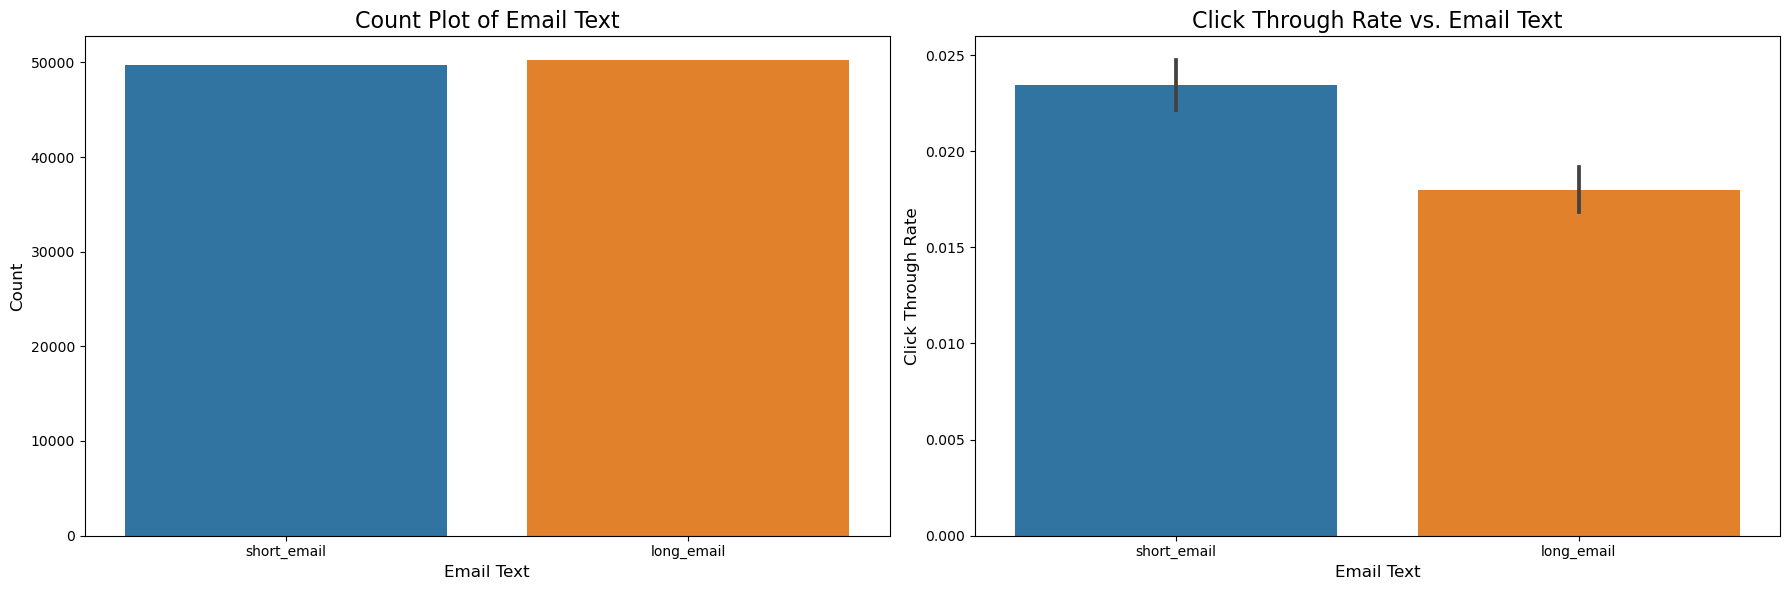

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_text', data=data, ax=ax[0])
ax[0].set_xlabel('Email Text', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Text', fontsize=16)

sns.barplot(x='email_text', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Text', fontsize=16)
plt.tight_layout()
plt.show()

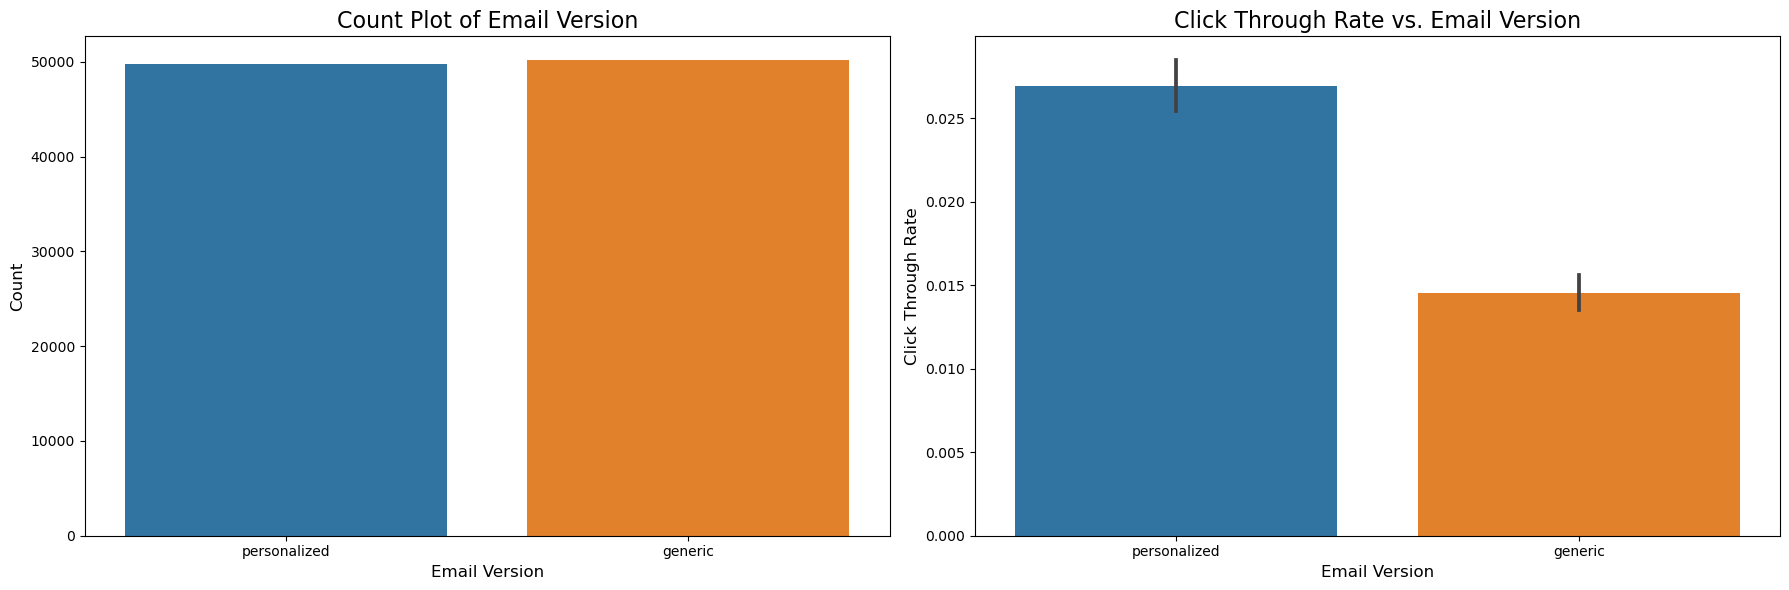

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_version', data=data, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)

sns.barplot(x='email_version', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.tight_layout()
plt.show()

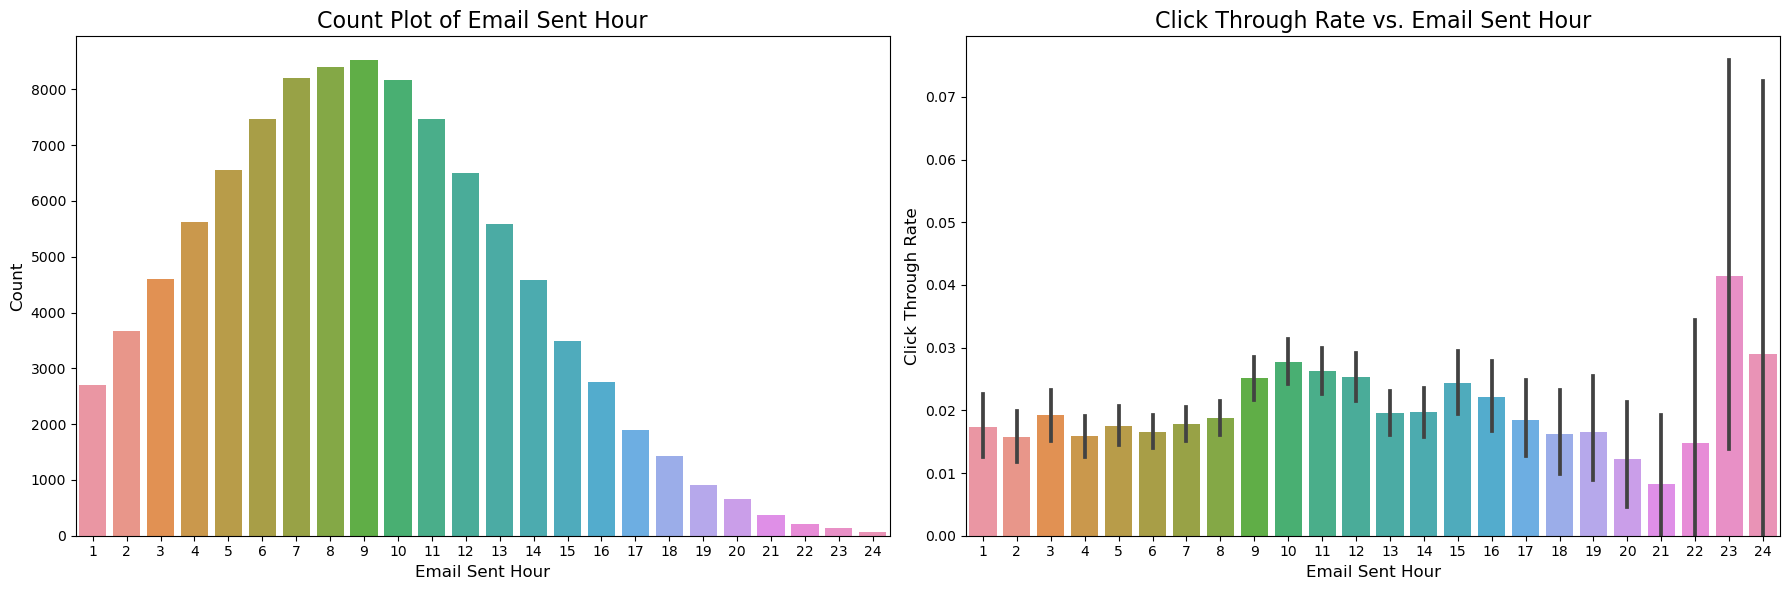

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)

sns.barplot(x='hour', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()

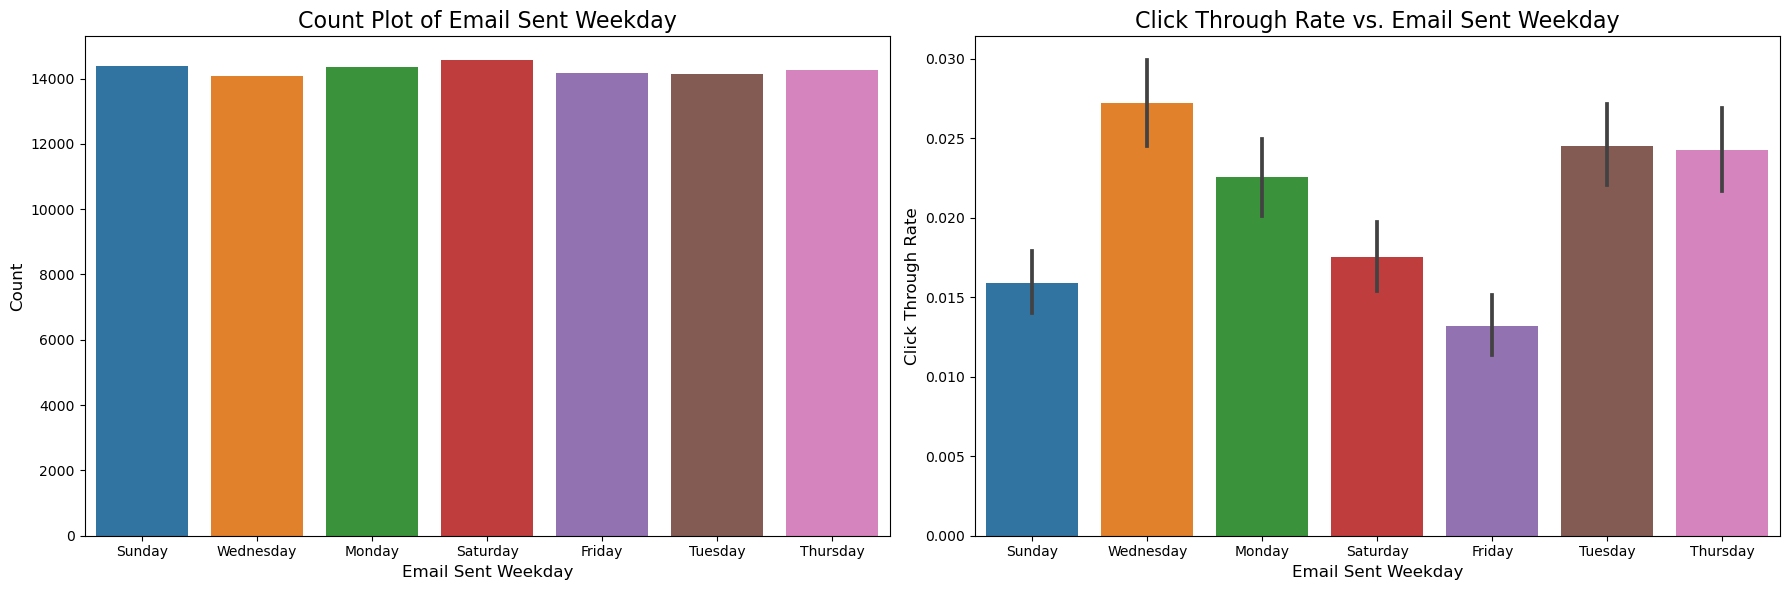

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='weekday', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Weekday', fontsize=16)

sns.barplot(x='weekday', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Weekday', fontsize=16)
plt.tight_layout()
plt.show()

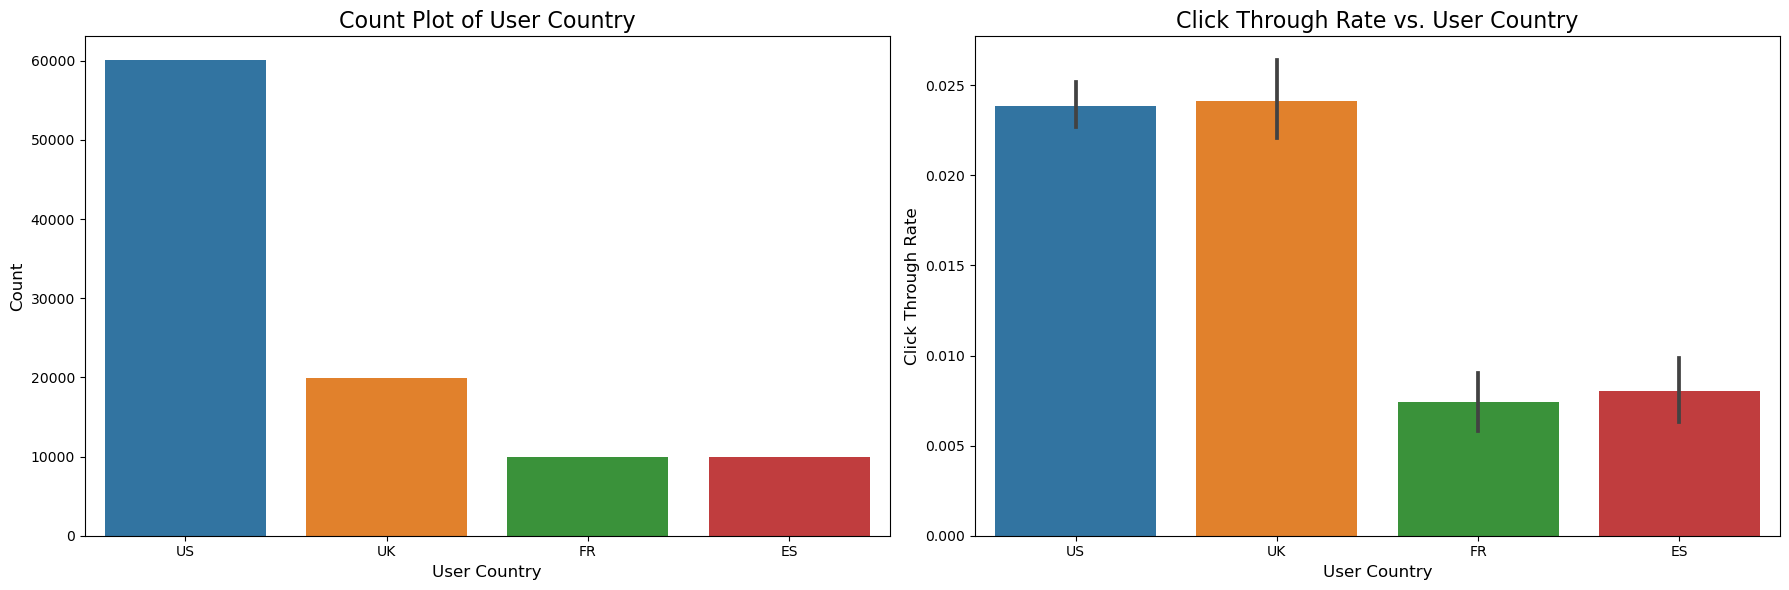

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_country', data=data, ax=ax[0])
ax[0].set_xlabel('User Country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Country', fontsize=16)

sns.barplot(x='user_country', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Country', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Country', fontsize=16)
plt.tight_layout()
plt.show()

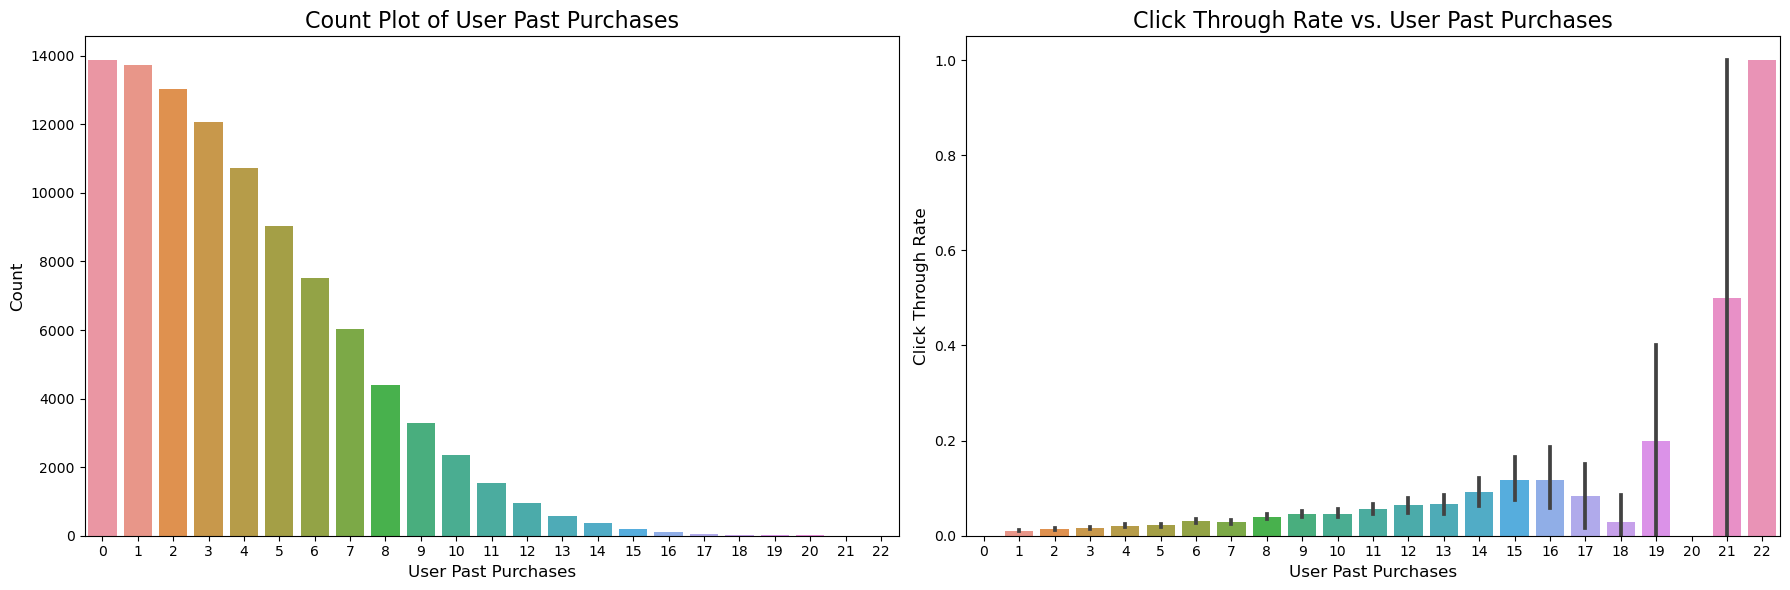

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_past_purchases', data=data, ax=ax[0])
ax[0].set_xlabel('User Past Purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Past Purchases', fontsize=16)

sns.barplot(x='user_past_purchases', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Past Purchases', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Past Purchases', fontsize=16)
plt.tight_layout()
plt.show()

### Machine Learning Models

In [27]:
import os
import h2o
from h2o.frame import H2OFrame

In [28]:
# Initialize H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 19.0.2+7-44, mixed mode, sharing)
  Starting server from C:\Users\YUWEN\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\YUWEN\AppData\Local\Temp\tmpem_lpurp
  JVM stdout: C:\Users\YUWEN\AppData\Local\Temp\tmpem_lpurp\h2o_YUWEN_started_from_python.out
  JVM stderr: C:\Users\YUWEN\AppData\Local\Temp\tmpem_lpurp\h2o_YUWEN_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_YUWEN_7ewefd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.936 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [29]:
data.drop(labels = ['opened'], axis = 1, inplace = True)
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0
1,966622,long_email,personalized,12,Sunday,UK,2,1
2,777221,long_email,personalized,11,Wednesday,US,2,0
3,493711,short_email,generic,6,Monday,UK,1,0
4,106887,long_email,generic,14,Monday,US,6,0


In [30]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)
h2o_df['clicked'] = h2o_df['clicked'].asfactor()

h2o_df.show_summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,clicked
type,int,enum,enum,int,enum,enum,int,enum
mins,8.0,,,1.0,,,0.0,
mean,498695.7290645283,,,9.059099549774954,,,3.878559279639822,
maxs,999998.0,,,24.0,,,22.0,
sigma,289226.1152436019,,,4.439618361673158,,,3.1963244414842515,
zeros,0,,,0,,,13872,
missing,0,0,0,0,0,0,0,0
0,85120.0,short_email,personalized,2.0,Sunday,US,5.0,0
1,966622.0,long_email,personalized,12.0,Sunday,UK,2.0,1
2,777221.0,long_email,personalized,11.0,Wednesday,US,2.0,0


In [31]:
# Split into 70% training and 30% test dataset

strat_split = h2o_df['clicked'].stratified_split(test_frac=0.3, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = 'clicked'

In [32]:
# Build Random Forest ModeL

model_rf = h2o.estimators.H2ORandomForestEstimator(model_id="RF_defaults", balance_classes=True, nfolds=10, seed=20)
model_rf.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: RF_defaults


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          1.41935e+06            20           20           20            1698          2837          2242.88

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.3976252819975603
RMSE: 0.6305753579054293
LogLoss: 1.2018462178137201
Mean Per-Class Error: 0.05573790001417829
AUC: 0.9681419601542379
AUCPR: 0.9538570386966129
Gini: 0.9362839203084758

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.022858138205920444
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      61167  7350   0.1073   (7350.0/68517.0)
1      288    68232  0.0042   (288.0/68520.0)
Total  61455  75582  0.0557   (7638.0/137037.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0228581    0.946996  359
max f2                       0.0180141    0.977002  363
max f0point5                 0.0282086    0.921104  354
max accuracy                 0.0228581    0.944263  359
max precision                1            1         0
max recall                   0.0122595    1         369
max specificity              1            1         0
max absolute_mcc             0.0228581    0.893283  359
max min_per_class_accuracy   0.0403259    0.915875  340
max mean_per_class_accuracy  0.0228581    0.944262  359
max tns                      1            68517     0
max fns                      1            68507     0
max fps                      2.64871e-05  68517     399
max tps                      0.0122595    68520     369
max tnr                      1            1         0
max fnr                      1            0.99981   0
max fpr                      2.64871e-05  1         399
max tpr                      0.0122595    1         369

Gains/Lift Table: Avg response rate: 50.00 %, avg score:  6.18 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100046                   0.379396           1.97953   1.97953            0.989788         0.506043     0.989788                    0.506043            0.0198044       0.0198044                  97.9534   97.9534            0.0196001
2        0.0200019                   0.300669           1.97806   1.9788             0.989051         0.33375      0.98942                     0.419928            0.0197752       0.0395797                  97.8059   97.8797            0.0391564
3        0.0300065                   0.259651           1.95765   1.97175            0.978848         0.278212     0.985895                    0.372678            0.0195855       0.0591652                  95.7652   97.1747            0.0583187
4        0.0400038                   0.232723           1.96492   1.97004            0.982482         0.245535     0.985042                    0.340904            0.0196439       0.0788091                  96.492    97.0041            0.0776123
5        0.0500011                   0.21274            1.94594   1.96522            0.972993         0.222361     0.982633             

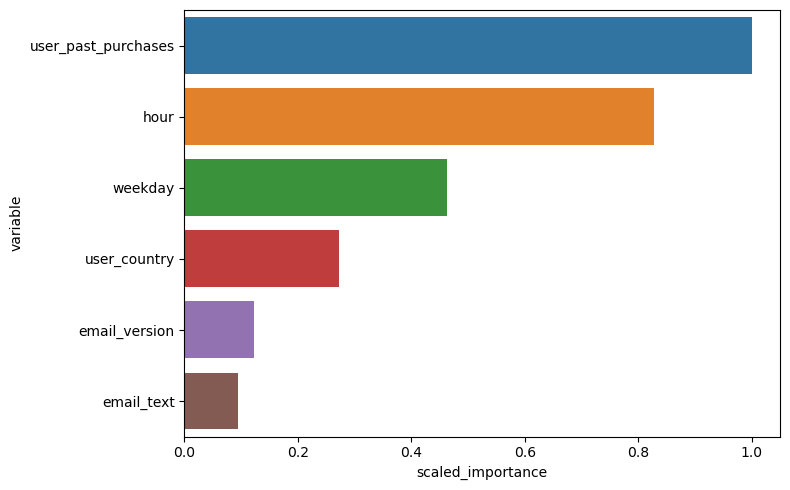

In [33]:
# Feature importance
importance = model_rf.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.tight_layout()
plt.show()

In [34]:
# Make predictions
train_true = train.as_data_frame()['clicked'].values
test_true = test.as_data_frame()['clicked'].values

train_pred = model_rf.predict(train).as_data_frame()['p1'].values
test_pred = model_rf.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [35]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29364
           1       0.00      0.00      0.00       621

    accuracy                           0.98     29985
   macro avg       0.49      0.50      0.49     29985
weighted avg       0.96      0.98      0.97     29985



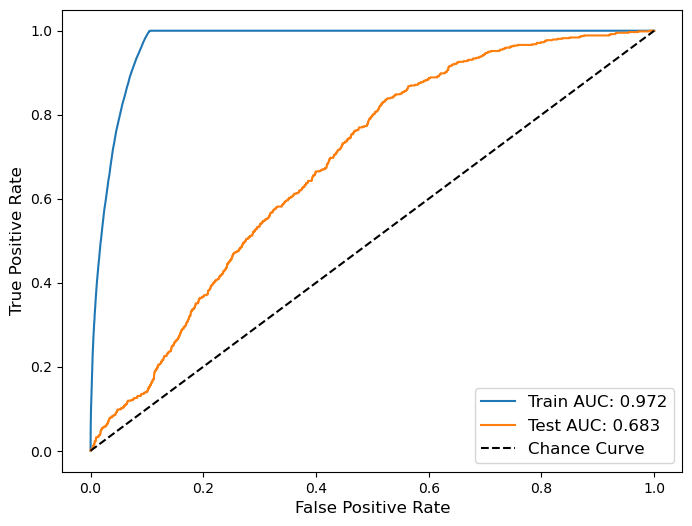

In [36]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
# ax.grid(True)
ax.legend(fontsize=12)
plt.show()

In [37]:
import h2o.grid
g = h2o.grid.H2OGridSearch(
 h2o.estimators.H2ORandomForestEstimator(balance_classes=True),
 hyper_params={
 "ntrees": [50, 100, 120],
 "max_depth": [40, 60],
 "min_rows": [1, 2]
 }
 )
g.train(x=feature, y=target, training_frame=train)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,max_depth,min_rows,ntrees,model_ids,logloss
,40.0,1.0,50.0,Grid_DRF_py_3_sid_a609_model_python_1677961039233_164_model_1,1.1735158
,60.0,1.0,120.0,Grid_DRF_py_3_sid_a609_model_python_1677961039233_164_model_10,1.1844288
,40.0,1.0,100.0,Grid_DRF_py_3_sid_a609_model_python_1677961039233_164_model_5,1.1911925
,60.0,1.0,50.0,Grid_DRF_py_3_sid_a609_model_python_1677961039233_164_model_2,1.1928532
,60.0,2.0,100.0,Grid_DRF_py_3_sid_a609_model_python_1677961039233_164_model_8,1.1939251
,40.0,1.0,120.0,Grid_DRF_py_3_sid_a609_model_python_1677961039233_164_model_9,1.1972460
,40.0,2.0,100.0,Grid_DRF_py_3_sid_a609_model_python_1677961039233_164_model_7,1.2005144
,60.0,1.0,100.0,Grid_DRF_py_3_sid_a609_model_python_1677961039233_164_model_6,1.2030672
,40.0,2.0,50.0,Grid_DRF_py_3_sid_a609_model_python_1677961039233_164_model_3,1.2046383
,40.0,2.0,120.0,Grid_DRF_py_3_sid_a609_model_python_1677961039233_164_model_11,1.2109819


In [38]:
# Build Random Forest ModeL

model_final = h2o.estimators.H2ORandomForestEstimator(model_id="RF_defaults", balance_classes=True, ntrees=50, max_depth=40 , min_rows=1 ,nfolds=10, seed=42)
model_final.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: RF_defaults


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          1.44574e+06            21           26           23.5          1499          2963          2284.84

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.39951069249940907
RMSE: 0.6320685821170113
LogLoss: 1.2014690237088301
Mean Per-Class Error: 0.05556266143018966
AUC: 0.9682642025542825
AUCPR: 0.9545125308381256
Gini: 0.9365284051085649

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.023001848321166238
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      61160  7357   0.1074   (7357.0/68517.0)
1      257    68267  0.0038   (257.0/68524.0)
Total  61417  75624  0.0556   (7614.0/137041.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0230018    0.947179  356
max f2                       0.0181722    0.977066  360
max f0point5                 0.0304142    0.920976  349
max accuracy                 0.0230018    0.94444   356
max precision                1            1         0
max recall                   0.0101646    1         368
max specificity              1            1         0
max absolute_mcc             0.0220485    0.893745  357
max min_per_class_accuracy   0.0409209    0.917218  334
max mean_per_class_accuracy  0.0230018    0.944437  356
max tns                      1            68517     0
max fns                      1            68523     0
max fps                      2.80476e-05  68517     399
max tps                      0.0101646    68524     368
max tnr                      1            1         0
max fnr                      1            0.999985  0
max fpr                      2.80476e-05  1         399
max tpr                      0.0101646    1         368

Gains/Lift Table: Avg response rate: 50.00 %, avg score:  6.01 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100043                   0.323792           1.98239   1.98239            0.991247         0.418883     0.991247                    0.418883            0.0198325       0.0198325                  98.2393   98.2393            0.0196573
2        0.0200013                   0.270671           1.98092   1.98166            0.990511         0.294182     0.990879                    0.356555            0.0198033       0.0396357                  98.0921   98.1657            0.0392709
3        0.0300056                   0.239925           1.97364   1.97898            0.986871         0.253903     0.989543                    0.322329            0.0197449       0.0593807                  97.3641   97.8985            0.0587531
4        0.0400026                   0.219168           1.96048   1.97436            0.980292         0.228943     0.987231                    0.298991            0.019599        0.0789796                  96.0484   97.4361            0.077958
5        0.0500069                   0.202271           1.95905   1.9713             0.979577         0.210326     0.9857               

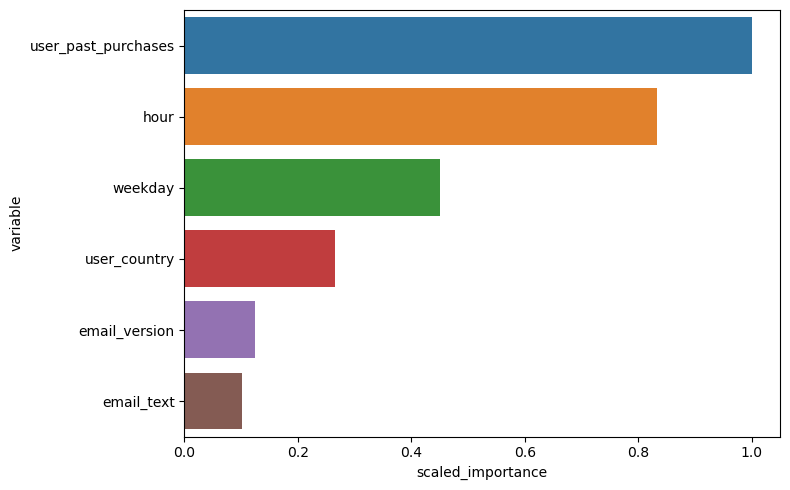

In [39]:
# Feature importance
importance = model_final.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.tight_layout()
plt.show()

In [40]:
# Make predictions
train_true = train.as_data_frame()['clicked'].values
test_true = test.as_data_frame()['clicked'].values

train_pred_final = model_final.predict(train).as_data_frame()['p1'].values
test_pred_final = model_final.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred_final)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred_final)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [41]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred_final > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29364
           1       0.00      0.00      0.00       621

    accuracy                           0.98     29985
   macro avg       0.49      0.50      0.49     29985
weighted avg       0.96      0.98      0.97     29985



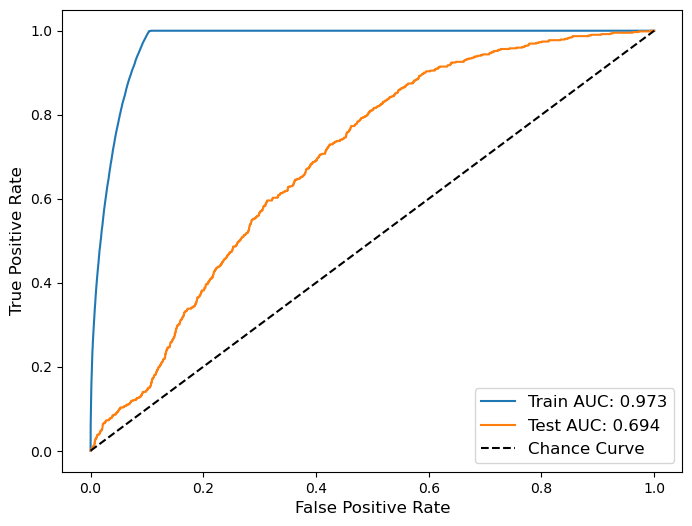

In [42]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
# ax.grid(True)
ax.legend(fontsize=12)
plt.show()

In [43]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_a609 closed.


### Q3: By how much do you think your model would improve click through rate (defined as # of users who click on the link / total users who received the email). How would you test that?

Based on the model built previously, the company can send email to selected users that are predicted to have higher probability to click the link.

To test it, we can conduct A/B test to see if the built model can actually help improve the click-through-rate.

- Randomly assign users to two groups, Control group and Experiment group.
- In Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.
- In Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
- Preform a one-tail unpaired t-test to test whether Experiement group's population proportion is higher than Control group's population proportion.

### Q4: Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

From the EDA, we can find that:
- Customers would be more likely to click to the website when email is short.
- Customers would be more likely to click to the website when emails have personalized content.
- Customers would be more likely to click to the website when emails were been sent from 23:00 to 24:00.
- Customers would be more likely to click to the website when emails were been sent on Wednesday.
- Customers from US and UK are more likely to click to the website.
- Customers who bought products from the websites more often would be more likely to click to the website.